# Quantifying SAM's performance on segmentation of crops in satellite imagery 

 * File Created: Sunday, 14th May 2023 9:10:24 pm
 * Author: Rutuja Gurav (rgura001@ucr.edu)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

1.13.1
True
8


In [3]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white',
        })

from scipy import ndimage
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import sys, glob, os, collections
from pprint import pprint

## Download SAM weights

Find explanation of SAM's parameters here - 
(SAM paper) https://arxiv.org/abs/2304.02643
(Blog) https://replicate.com/pablodawson/segment-anything-automatic

In [4]:
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-06-20 16:57:20--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘cached_models/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  94.2MB/s    in 23s     

2023-06-20 16:57:43 (106 MB/s) - ‘cached_models/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2023-06-20 16:57:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [

## Example: Segmenting CalCrop21 Images

CalCrop21[1] is a benchmark dataset that contained 4D spatiotemporal multispectral tiles of satellite imagery from Sentinel-2 satellite for the year 2018 for Central Valley, CA agricultural fields along with the corresponding ground-truth crop-map (CDL) for each tile. As SAM is limited to 3-channel RGB inputs, we have to use RGB channels from an appropriate timestep in the year. We have decided this appropriate timestep to be the maximum NDVI timestep.  

[1] Ghosh, Rahul, et al. "Calcrop21: A georeferenced multi-spectral dataset of satellite imagery and crop labels." 2021 IEEE International Conference on Big Data (Big Data). IEEE, 2021.

### [TESTING] Creating RGB composite and saving them at different AOI sizes.

Note: This is implemented in make_aoi_samples.py. Run that script in background for larger datasets, do not run this in notebook.

In [5]:
import glob
DATA_DIR = "/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS"
filepaths = glob.glob(DATA_DIR+"/IMAGE_GRIDS/*.npy")
print(len(filepaths))
print(filepaths[:2])
tile_ids = [fp.split('/')[-1].rsplit('_',1)[0] for fp in filepaths]
print(tile_ids[:2])

367
['/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS/IMAGE_GRIDS/T10SFH_2018_2_1_IMAGE.npy', '/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS/IMAGE_GRIDS/T11SKV_2018_4_9_IMAGE.npy']
['T10SFH_2018_2_1', 'T11SKV_2018_4_9']


Compute NDVI cube for a tile, then use max NDVI timestep to create RGB render.

NDVI = (B8-B4) / (B8+B4)

In [5]:
with open("/home/rgura001/segment-anything/sam4crops/unusable_tiles.txt", 'r') as file:
    unusable_tiles = [line.rstrip() for line in file]
    
print(len(unusable_tiles))

20


In [ ]:
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor
import skimage
from PIL import Image
from utils import plot_sample

overlap = 0.5
SAVE_DIR = "/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_{}".format(overlap)
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

def make_aoi_samples(i, id_):
    image_multispec = np.load(DATA_DIR+"/IMAGE_GRIDS/{}_IMAGE.npy".format(id_))
    gt_mask = np.load(DATA_DIR+"/PREPROCESSED_CDL_GRIDS/{}_PREPROCESSED_CDL_LABEL.npy".format(id_))
    # print(image_multispec.shape, gt_mask.shape)

    B4, B8 = image_multispec[:,2,:,:], image_multispec[:,6,:,:]
    image_ndvi = np.divide((B8-B4), (B8+B4), out=np.zeros_like(B8), where=B4!=0)
    # print(image_ndvi.shape)
    max_ndvi_timestep = np.argmax(np.mean(image_ndvi, axis=(1,2)))
    # sorted_ndvi_timesteps = np.mean(image_ndvi, axis=(1,2)).argsort()[-24:][::-1]
    # print(max_ndvi_timestep)
    image = image_multispec[max_ndvi_timestep,[0,1,2],:,:].T * 255
    image = image.astype(int)
    # print(image.shape, image.min(), image.max())

    image = ndimage.rotate(np.fliplr(image), angle=90).astype('uint8')

    datapoint = np.concatenate((image, gt_mask[..., np.newaxis]), axis=-1) 
    max_shape = datapoint.shape[0]
    for split_ratio in [2, 4, 8, 16]:
        window_size = (max_shape//split_ratio, max_shape//split_ratio, datapoint.shape[-1])
        # views = np.lib.stride_tricks.sliding_window_view(datapoint, window_size, axis=(0,1))
        views = skimage.util.view_as_windows(datapoint, window_size, step=int(overlap*window_size[0])).squeeze()
        # print(views.shape)
        
        samples = views.reshape(-1, views.shape[2], views.shape[3], views.shape[4])
        # print(samples.shape)
        
        aoi_save_dir = SAVE_DIR+"/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(samples.shape[1])
        if not os.path.exists(aoi_save_dir):
            os.makedirs(aoi_save_dir)
        
        for sample_idx in range(samples.shape[0]):
            sample = samples[sample_idx, ...] #[np.newaxis,...]
            # print(sample.shape)
            np.save(aoi_save_dir+"/{}_sample_{}_maxNDVItimestep_rgb_size_{}.npy"
                .format(id_, sample_idx, sample.shape[1]), sample)

        ##-----------DEBUG----------------------
        # plot_sample(img=sample[...,:3], mask=sample[...,-1], titlestr="Tile ID: {}, Sample #{}".format(id_, sample_idx), 
        #         show=True)
        ##--------------------------------------

## Ususable tiles are either all black in RGB or are too contaminated with clouds 
# and errors introduced while removing them...
usable_tile_ids = [_id for _id in tile_ids if _id not in unusable_tiles]
results = Parallel(n_jobs=-1, verbose=1)(delayed(make_aoi_samples)(i, _id) for i, _id in tqdm(enumerate(usable_tile_ids[:2])))
# print(results)
get_reusable_executor().shutdown(wait=True)

This is for mapping CalCrop21 crop-types with their CDL values so that I can visualize the CDL ground-truth appropriately.

In [6]:
class_names = ['Background','Corn','Cotton','Rice','Sunflower','Barley','Winter Wheat','Safflower','Dry Beans','Onions','Tomatoes','Cherries','Grapes','Citrus','Almonds','Walnuts','Pistachios','Garlic','Olives','Pomegranates','Alfalfa','Other Hay/Non Alfalfa','Barren','Fallow/Idle Cropland','Forest','Grassland/Pasture','Wetlands','Water','Developed']
labels_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
print(len(class_names), len(labels_list))

crop_legend = pd.read_csv("/data/rgura001/AI4CP/crop_legend_multilevel_encoded.csv")

cdl_values_list = []
for class_name in class_names:
    val = crop_legend[crop_legend['Crops_Level_1'] == class_name]['Crops_Level_1_enc'].to_list()[0]
    cdl_values_list.append(val)

print(cdl_values_list)
print(len(class_names), len(labels_list), len(cdl_values_list))

### Visualize Samples

In [5]:
## PPS as fraction of image length and width
aoi_length = 137
print("PPS")
pps_frac_vals =  [1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1] #[1e-1, 1.25e-1, 2.5e-1]
print(pps_frac_vals, [f"{pps_frac*100}%" for pps_frac in pps_frac_vals])
pps_vals = [np.ceil(aoi_length*pps_frac).astype(int) for pps_frac in pps_frac_vals]
print(pps_vals)

## MMRA as a fraction of image area
print("MMRA")
min_mask_region_fracs_vals = [1e-3, 5*1e-3, 1e-2, 5*1e-2, 1e-1]
print(min_mask_region_fracs_vals, [f"{min_mask_region_frac*100}%" for min_mask_region_frac in min_mask_region_fracs_vals])
min_mask_region_area_vals = [np.ceil(aoi_length*aoi_length*min_mask_region_frac).astype(int) for min_mask_region_frac in min_mask_region_fracs_vals]
print(min_mask_region_area_vals)

PPS
[0.01, 0.025, 0.05, 0.075, 0.1] ['1.0%', '2.5%', '5.0%', '7.5%', '10.0%']
[2, 4, 7, 11, 14]
MMRA
[0.001, 0.005, 0.01, 0.05, 0.1] ['0.1%', '0.5%', '1.0%', '5.0%', '10.0%']
[19, 94, 188, 939, 1877]


In [11]:
aoi_sizes = [1098, 549, 274, 137, 68]
aoi_size = aoi_sizes[0]
SAMPLES_DIR = "/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(aoi_size)
sample_filepaths = sorted(glob.glob(SAMPLES_DIR+"/*.npy"))
print(len(sample_filepaths), sample_filepaths[:2])

347 ['/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_1098/T10SEH_2018_1_9_sample_86_maxNDVItimestep_rgb_size_1098.npy', '/data/rgura001/AI4CP/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_1098/T10SEH_2018_2_1_sample_29_maxNDVItimestep_rgb_size_1098.npy']


In [12]:
num_samples=10
num_avail_samples = len(sample_filepaths)
if num_avail_samples >= num_samples:
    np.random.seed(42)
    sample_idxes = np.random.randint(low=0, high=num_avail_samples, size=num_samples)
else:
    print("num_samples greater than num_avail_samples(={})! Exiting...".format(num_avail_samples))
    # sys.exit()
print(sample_idxes)

[102 270 106  71 188  20 102 121 214 330]


106 (1098, 1098, 4)
(1098, 1098, 3) (1098, 1098)


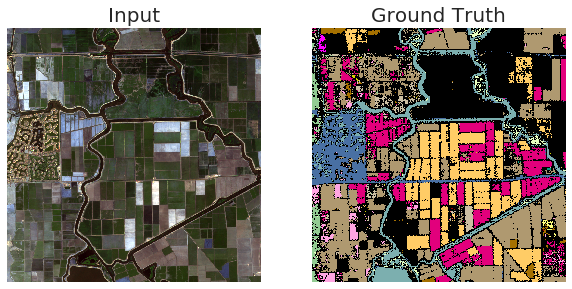

In [13]:
i = 2
sample_id = sample_idxes[i]
sample = np.load(sample_filepaths[sample_id])    
print(sample_idxes[i], sample.shape)

image, gt_mask = sample[...,:3].astype('uint8'), sample[...,-1] ## because SAM expects uint8 inputs
print(image.shape, gt_mask.shape)

from utils import plot_sample
plot_sample(img=image, mask=gt_mask)

In [14]:
num_classes_in_gt_mask = len(np.unique(gt_mask))
num_classes_in_gt_mask

20

### Visualize Prediction

In [15]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

MODEL_DIR = "/home/rgura001/segment-anything/sam4crops/cached_models"
model_type = "vit_h"
sam_checkpoint = [fp for fp in glob.glob(MODEL_DIR+'/*.pth') if model_type in fp][0]
print(sam_checkpoint)
device = "cuda:7"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=device)

/home/rgura001/segment-anything/sam4crops/cached_models/sam_vit_h_4b8939.pth


Full explanation of all options available in `SamAutomaticMaskGenerator` can be found here - https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

  0%|          | 0/1 [00:00<?, ?it/s]

1 1
Defining mask generator...
DONE!
Generating masks...
For sample 106, SAM generated 413 boolean masks!
Max cluster id = 255
num_labels_in_pred_mask = 248
DONE!
Evaluating clustering consensus...
DONE!
Plotting...


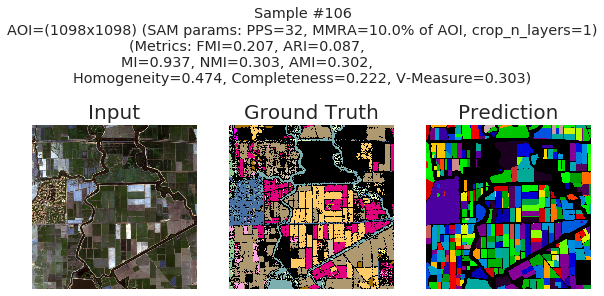

DONE!


In [16]:
from utils import plot_prediction, eval_clustering

img_w, img_h = aoi_size, aoi_size
min_mask_region_fracs_vals = [1e-1]
# min_mask_area_vals = [int(min_mask_area_frac*img_w*img_h) for min_mask_area_frac in min_mask_region_frac_vals]
pps_vals = [32]
crop_n_layers_vals = [1]
crop_n_points_downscale_factor = 1

for pps in pps_vals:
    for min_mask_area_frac in tqdm(min_mask_region_fracs_vals, leave=False):
        min_mask_area = int(min_mask_area_frac*img_w*img_h)
        min_mask_area_perc = min_mask_area_frac*100
        for crop_n_layers in crop_n_layers_vals:
            # for crop_n_points_downscale_factor in crop_n_points_downscale_factor_vals:
            # try:
            print(crop_n_layers, crop_n_points_downscale_factor)
            
            titlestr = "AOI=({}x{}) (SAM params: PPS={}, MMRA={}% of AOI, crop_n_layers={})"\
                        .format(img_w, img_h, pps, min_mask_area_perc, crop_n_layers)
            # print(titlestr)

            print("Defining mask generator...")
            mask_generator = SamAutomaticMaskGenerator(model=sam,
                                                        points_per_side=pps,
                                                        pred_iou_thresh=0.95,
                                                        stability_score_thresh=0.95,
                                                        # box_nms_thresh=0.0,
                                                        # crop_nms_thresh=0.0,
                                                        crop_n_layers=crop_n_layers,
                                                        crop_n_points_downscale_factor=crop_n_points_downscale_factor,
                                                        min_mask_region_area=min_mask_area,  # Requires open-cv to run post-processing
                                                    )
            print("DONE!")

            print("Generating masks...")
            masks = mask_generator.generate(image)
            # print(masks[0].keys())
            print("For sample {}, SAM generated {} boolean masks!".format(sample_id, len(masks)))
            ## Sort masks by stability score
            masks = sorted(masks, key=lambda d: d['stability_score']) 

            ## How many pixels got no mask?
            # pred_mask = np.logical_or.reduce(np.array([mask['segmentation'] for mask in masks]), axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Checking for any overlap in the masks
            # bin_masks = np.array([np.array(mask['segmentation']).astype(int) for mask in masks])
            # print(collections.Counter(bin_masks.flatten()))
            # pred_mask = np.sum(bin_masks, axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Transform N boolean overlapping masks into one numerically encoded mask
            pred_mask = np.zeros((image.shape[0], image.shape[1]))
            # pred_mask = masks[0]['segmentation'].astype(int)
            for i in range(len(masks)):
                val = i+1
                pred_mask += masks[i]['segmentation'].astype(int) * val
                pred_mask = np.where(pred_mask > val, val, pred_mask)
            pred_mask = pred_mask.astype('uint8')
            print(f"Max cluster id = {pred_mask.flatten().max()}")
            print(f"num_labels_in_pred_mask = {len(np.unique(pred_mask))}")
            print("DONE!")

            print("Evaluating clustering consensus...")